# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization import (
rg_step, renormalized_field, dH_dH, G_r_prime, G_prime, phi_from_G)
from utils import build_J

In [2]:
def find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=100, tol=1e-5,
            growth_threshold=1e3, decay_threshold=1e-3):

    if not (0 < a <= 2):
        raise ValueError("a must be in (0,2)")

    def grows(J0):
        J = build_J(J0, a, D=max_distance)
        J1_initial = abs(J[1])

        for _ in range(10):

            # early decision:
            if abs(J[1]) > growth_threshold:
                return True   # flows to ordered phase
            if abs(J[1]) < decay_threshold:
                return False  # flows to disordered phase

            # apply full RG step
            J = rg_step(J, a)

        # fallback: check increasing or decreasing tendency
        return abs(J[1]) > J1_initial

    # Bisection on J0: growth → ordered, decay → disordered
    while (Jhigh - Jlow) > tol:
        Jmid = 0.5 * (Jlow + Jhigh)
        if grows(Jmid):
            Jhigh = Jmid
        else:
            Jlow = Jmid

    return 0.5 * (Jlow + Jhigh)


def magnetization(J0, a, Jc, D, n_steps=10, eps=1e-6):
    # Disordered side
    if J0 <= Jc:
        return 0.0

    # Ordered sink magnetization (by convention)
    M_sink = 1.0

    # Spatial dimension & rescaling factor
    b = 3.0
    d = 1.0

    # Initial couplings
    J = build_J(J0, a, D)

    prod_R = 1.0
    k = 0

    for step in range(n_steps):
        dH = dH_dH(J, eps=eps)
        if not np.isfinite(dH) or dH <= 0.0:
            break

        prod_R *= dH
        k += 1

        J = rg_step(J, a)

    if k == 0:
        return 0.0

    scale = (b ** (-d)) ** k
    M0 = scale * prod_R * M_sink
    return float(M0)


def generate_rg_flow(J0, a, D, n_steps):

    J = build_J(J0, a, D)
    flow = [J.copy()]
    
    for _ in range(n_steps):
        J = rg_step(J, a)
        flow.append(J.copy())
    
    return flow


def plot_rg_flow(flow, distances_to_plot=None):

    n_steps_plus_1 = len(flow)
    D = len(flow[0]) - 1
    steps = np.arange(n_steps_plus_1)

    if distances_to_plot is None:
        distances_to_plot = [1, 2, 3, 4, 5]

    plt.figure(figsize=(7, 5))
    for r in distances_to_plot:
        if 1 <= r <= D:
            vals = np.array([J[r] for J in flow])
            plt.plot(steps, vals, marker='o', label=f"J_{r}")

    plt.xlabel("RG step")
    plt.ylabel("Coupling J_r")
    plt.title("Fixed-length RG flow of couplings")
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_Jc_over_a(a_values, max_distance):
    Jc_values = []
    for a in a_values:
        Jc = find_Jc(a, max_distance=max_distance)
        Jc_values.append(Jc)
    return np.array(Jc_values)

# RG flow

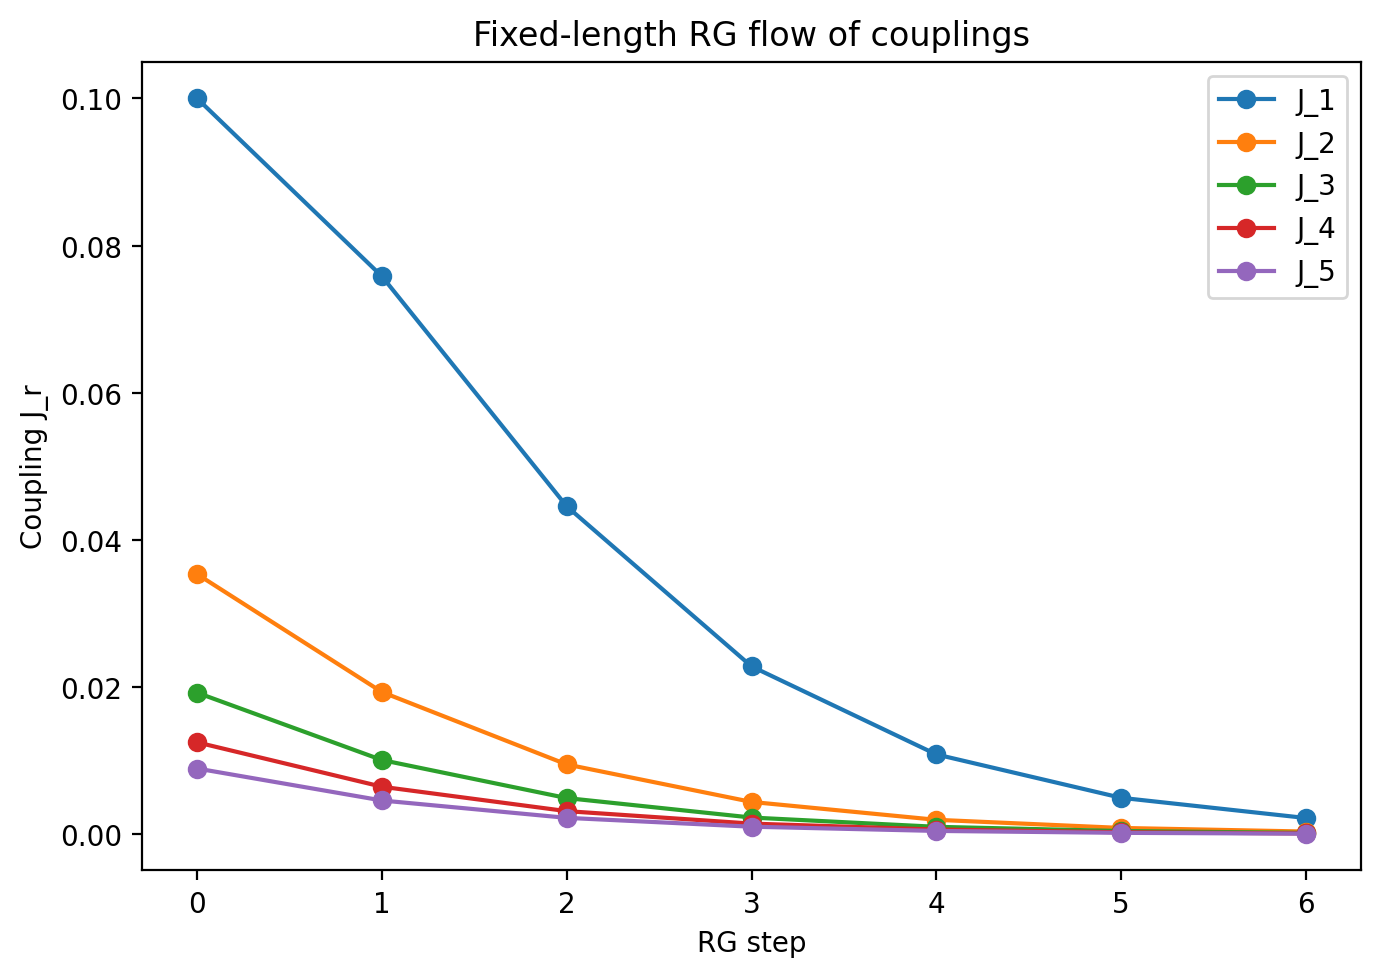

In [3]:
a = 1.5
D = 100
n_steps = 6

J0 = .1

flow = generate_rg_flow(J0, a, D, n_steps)
plot_rg_flow(flow, distances_to_plot=[1, 2, 3, 4, 5])

# Critical temperature line

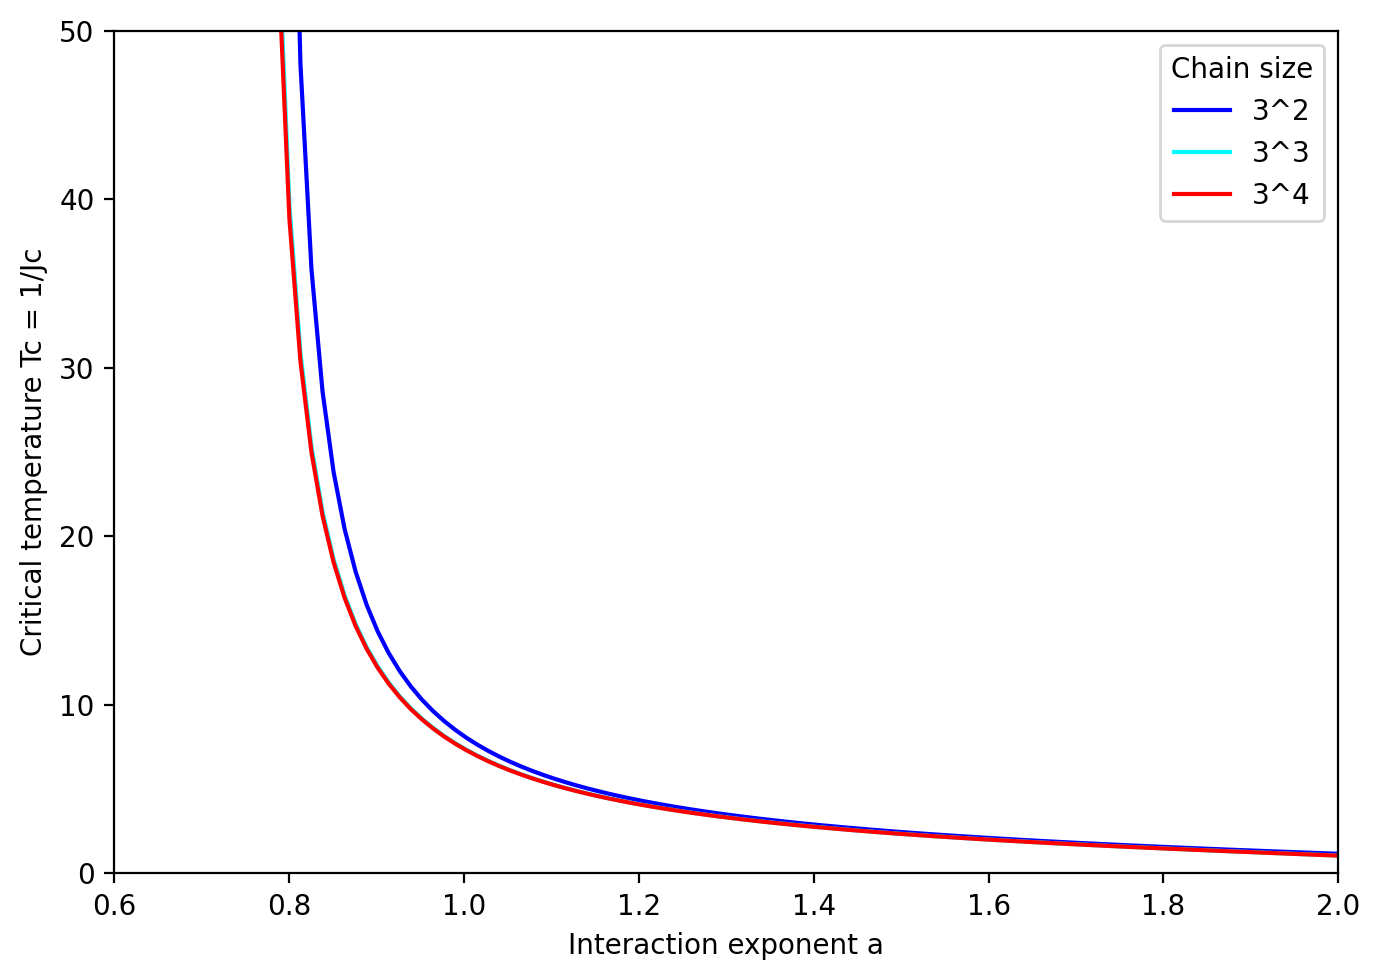

In [15]:
# Range of exponents
a_values = np.linspace(0.75, 2.0, 100)

plt.figure(figsize=(7, 5))
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**2), c='b', label='3^2')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**3), c='cyan', label='3^3')
plt.plot(a_values, 1/compute_Jc_over_a(a_values, 3**4), c='r', label='3^4')
plt.xlabel("Interaction exponent a")
plt.ylabel("Critical temperature Tc = 1/Jc")
plt.legend(title='Chain size')
plt.xlim(0.6, 2)
plt.ylim(0, 50)
plt.tight_layout()
plt.show()

# Magnetization

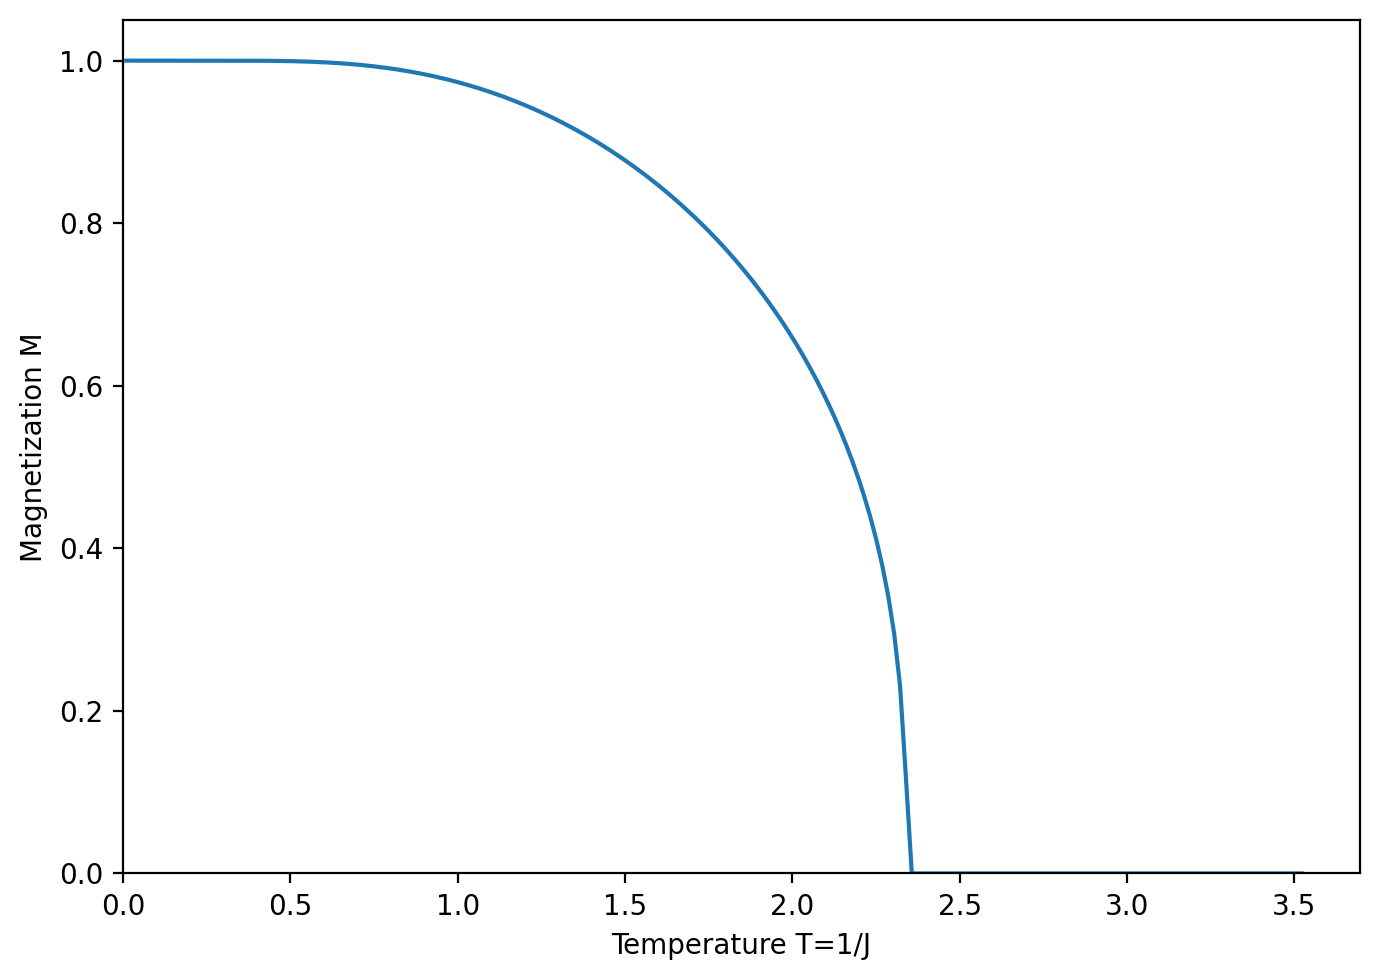

In [25]:
a = 1.5

if a < 0.8:
    Jc = 1e-10
    T_vals = np.linspace(0.01, 100, 200)
    J_vals = 1.0 / T_vals
else:
    Jc = find_Jc(a, Jlow=1e-2, Jhigh=1e2, max_distance=100, tol=1e-6, growth_threshold=1e3, decay_threshold=1e-3)
    T_vals = np.linspace(0.01, 1.5 / Jc, 200)
    J_vals = 1.0 / T_vals

M_vals = [
    magnetization(J0, a, Jc, D=1000, n_steps=12)
    for J0 in J_vals]

plt.figure(figsize=(7, 5))
plt.plot(T_vals, M_vals, '-', markersize=3)
plt.xlabel(r"Temperature T=1/J")
plt.ylabel(r"Magnetization M")
plt.xlim(0, None)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

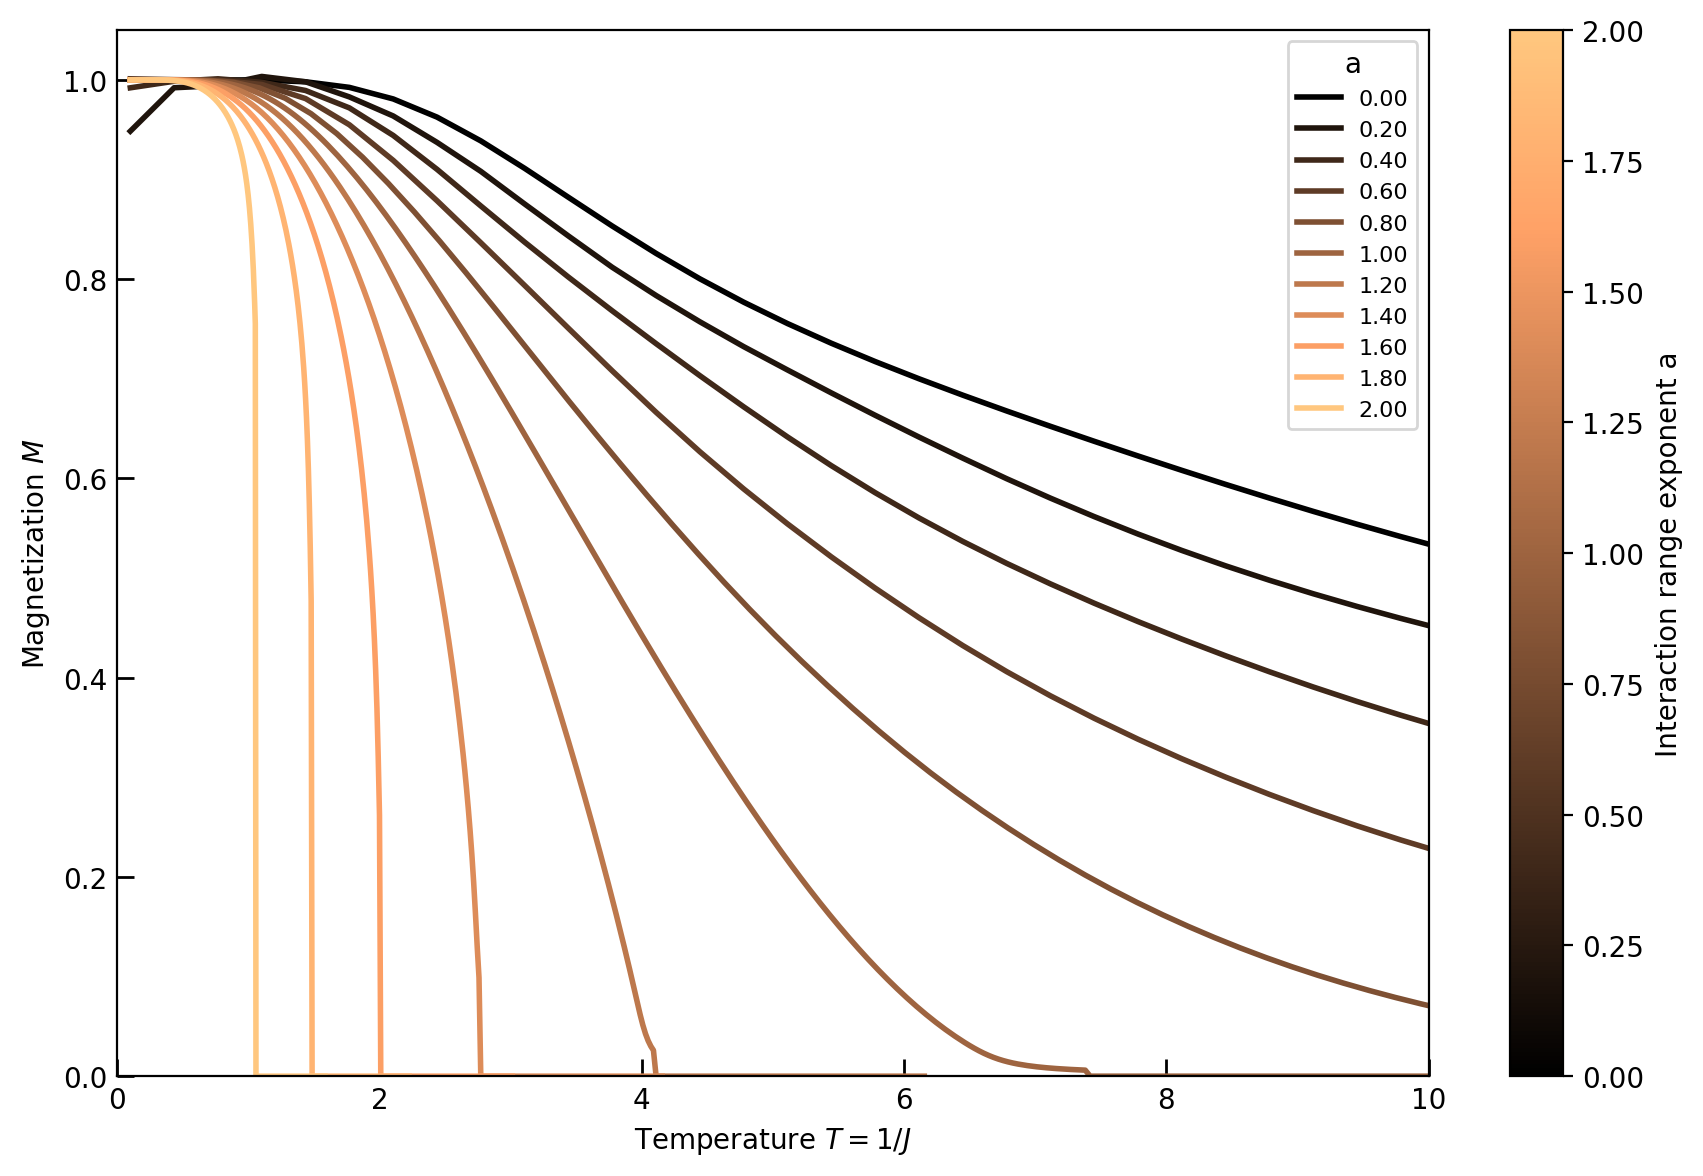

In [27]:
D = 100
n_steps_Jc = 10
n_steps_M  = 10
eps = 1e-6

a_values = np.linspace(0, 2, 11)
data_by_a = []

for a in a_values:
    if a < 0.8:
        Jc = 1e-12
        T_arr = np.linspace(0.1, 100, 300)
        J_arr = 1.0 / T_arr

    else:
        Jc = find_Jc(a)
        T_arr = np.linspace(0.10, 1.5 / Jc, 300)
        J_arr = 1.0 / T_arr

    # compute magnetization curve
    M_arr = np.array([
        magnetization(J0, a, Jc, D=D, n_steps=n_steps_M, eps=eps)
        for J0 in J_arr
    ])

    data_by_a.append((T_arr, M_arr))


from matplotlib import cm
fig, ax = plt.subplots(figsize=(9, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for a, (T_arr, M_arr) in zip(a_values, data_by_a):
    ax.plot(T_arr, M_arr,
            color=cmap(norm(a)),
            linewidth=2,
            label=f"{a:.2f}")
# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Interaction range exponent a')

ax.set_xlabel(r"Temperature $T = 1/J$")
ax.set_ylabel(r"Magnetization $M$")
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.05)
ax.legend(title="a", fontsize=8, framealpha=0.8)
ax.tick_params(axis='both', direction='in', width=1, length=6)
plt.tight_layout()
plt.show()

# Energy densities

In [3]:
def u_r(T, a, r_list, max_steps=8, D_fixed=100, dJ_rel=1e-3):
    J0 = 1.0 / T
    r_list = np.array(r_list, dtype=np.int64)

    J_base = build_J(J0, a, D_fixed)
    
    results = {}
    for r in r_list:
        J_r0 = J_base[r]
        dJ = dJ_rel * abs(J_r0) if J_r0 != 0 else dJ_rel

        Jp = J_base.copy()
        Jp[r] = J_r0 + dJ

        phi_p = phi_from_G(Jp, max_steps, a)
        phi = phi_from_G(J_base, max_steps, a)
        dphi_dJr = abs(phi_p - phi) / dJ
        results[r] = dphi_dJr / D_fixed
    return results

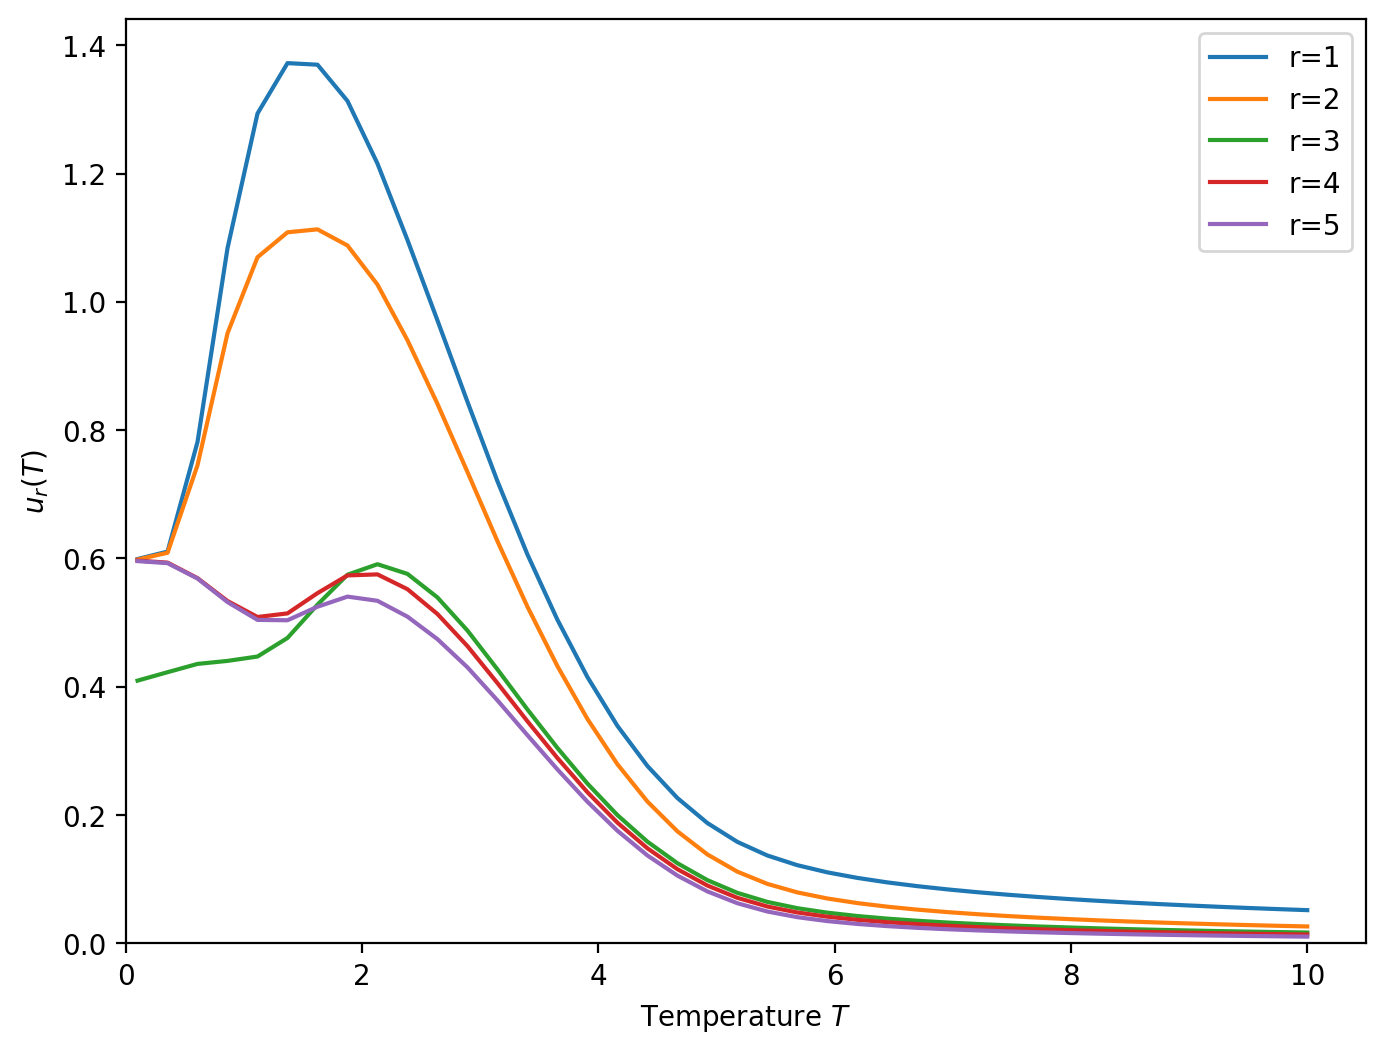

In [6]:
a = 1.
r_values = [1, 2, 3, 4, 5]
T_values = np.linspace(0.1, 10, 40)
u_results = {r: [] for r in r_values}

for T in T_values:
    ur_dict = u_r(T, a, r_values, max_steps=6, D_fixed=30, dJ_rel=1e-3)
    for r in r_values:
        u_results[r].append(ur_dict[r])

plt.figure(figsize=(8, 6))
for r in r_values:
    plt.plot(T_values, u_results[r], label=f"r={r}")
plt.xlim(0, None)
plt.ylim(0, None)
plt.xlabel("Temperature $T$")
plt.ylabel("$u_r(T)$")
plt.legend()
plt.show()

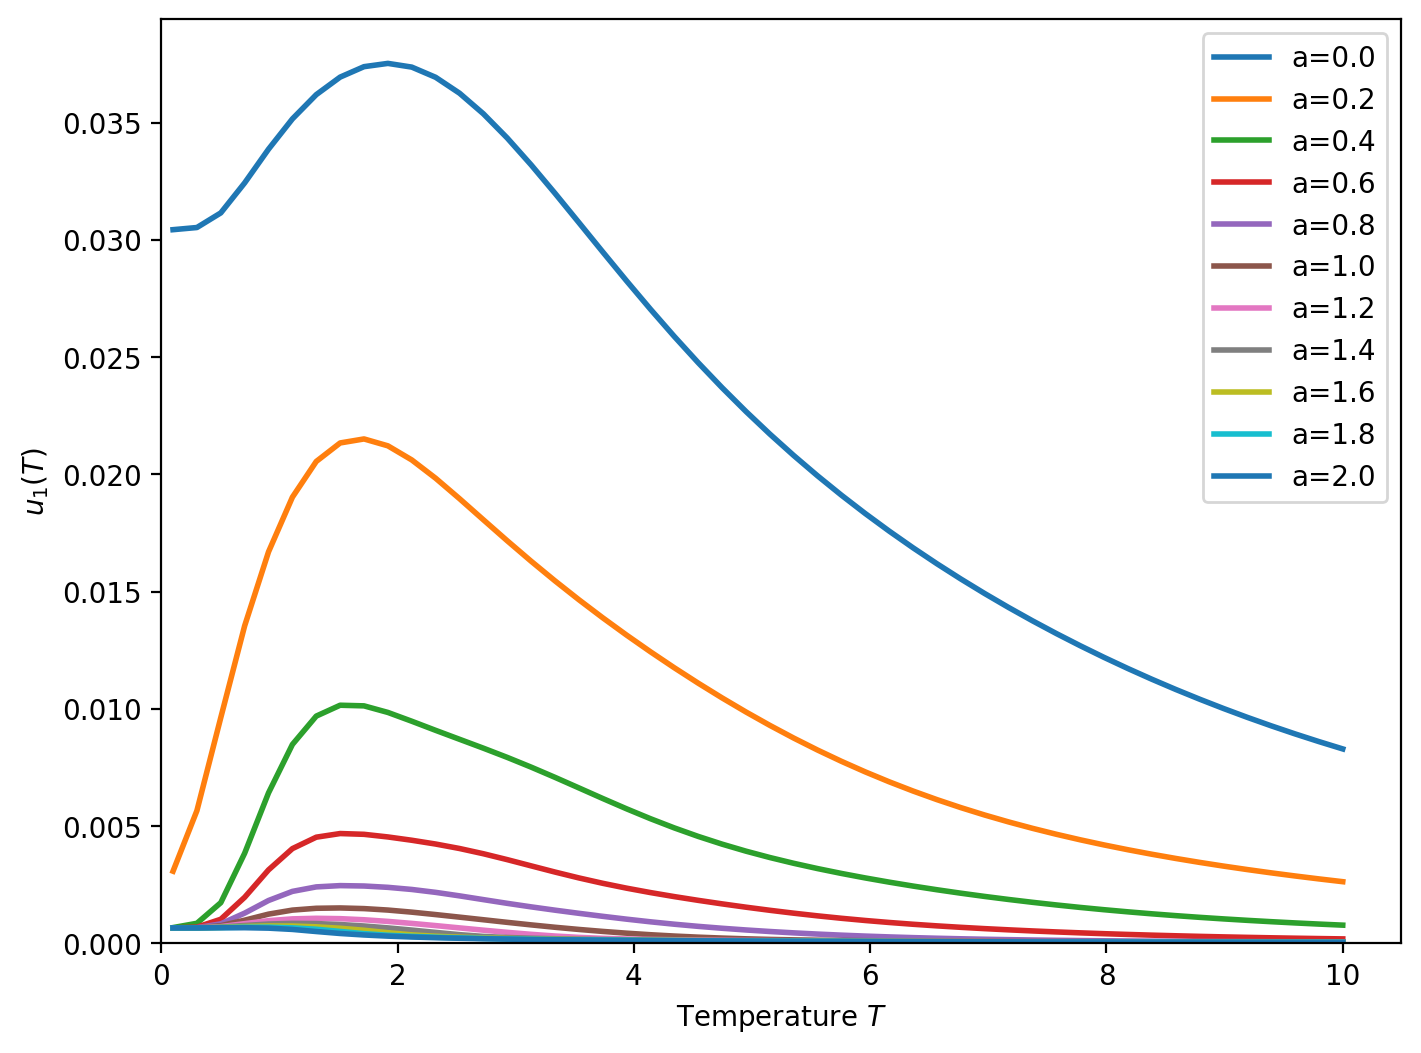

In [103]:
r_values = [1]
a_values = np.linspace(0, 2, 11)
T_values = np.linspace(0.1, 10, 50)

u_results = {a: {r: [] for r in r_values} for a in a_values}

for a in a_values:
    for T in T_values:
        ur_dict = u_r(T, a, r_values, max_steps=6, D_fixed=3**6, dJ_rel=1e-3)
        for r in r_values:
            u_results[a][r].append(ur_dict[r])

for r in r_values:
    plt.figure(figsize=(8, 6))
    for a in a_values:
        plt.plot(T_values, u_results[a][r], label=f"a={round(a,3)}", lw=2)
    plt.xlim(0, None)
    plt.ylim(0, None)
    plt.xlabel("Temperature $T$")
    plt.ylabel(f"$u_{r}(T)$")
    plt.legend()
    plt.show()

# Fixed point

In [4]:
def build_J_from_head(J_head, a, D, anchor_at_n=True):
    n = len(J_head) - 1
    J = np.zeros(D + 1, dtype=np.float64)
    J[1:n+1] = J_head[1:n+1]

    if anchor_at_n:
        anchor = J[n]
        for r in range(n + 1, D + 1):
            J[r] = anchor * (n / r) ** a
    else:
        pass # zero tail (hard cutoff)

    return J


def rg_map(J_head, a, D, n):
    J_full = build_J_from_head(J_head, a, D, anchor_at_n=True)
    Jp_full = rg_step(J_full, a=a)
    
    Jp = np.zeros(n + 1, dtype=np.float64)
    Jp[1:n+1] = Jp_full[1:n+1]
    
    return Jp, Jp_full


def fixed_point_solver(
    a, D=200, n=50, x0_head=None, max_iter=25, tol_F=1e-10, tol_dx=1e-10,
    eps0=1e-7, damping_init=1.0, max_backtrack=12, verbose=True,):

    # Consistency: n must lie in the exact head region of rg_step
    r_max = (D - 2) // 3
    if n > r_max:
        raise ValueError(f"Choose n <= r_max. Here D={D} gives r_max={r_max}, but n={n}.")

    # Initialize x
    if x0_head is None:
        raise ValueError("Provide x0_head (head vector length n+1) as initial guess.")
    x = x0_head.astype(np.float64).copy()
    x[0] = 0.0

    def residual_and_map(x_head):
        xp_head, Jp_full = rg_map(x_head, a=a, D=D, n=n)
        F = xp_head[1:n+1] - x_head[1:n+1]
        return F, xp_head, Jp_full

    # Initial residual
    F, xp_head, Jp_full = residual_and_map(x)
    F_norm = np.linalg.norm(F)
    if verbose:
        print(f"[Newton] init: ||F|| = {F_norm:.3e}  (D={D}, n={n}, r_max={r_max})")

    for it in range(1, max_iter + 1):
        # Check convergence
        if F_norm < tol_F:
            J_star_full = build_J_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {"converged": True,
                                    "iterations": it - 1,
                                    "F_norm": F_norm,}

        # Build Jacobian of F: J_F = d(R_n)/dx - I
        # Compute d(R_n)/dx via forward finite differences.
        JF = np.zeros((n, n), dtype=np.float64)

        # Baseline mapped head xp_head already computed above.
        base_xp = xp_head.copy()

        for j in range(1, n + 1):
            step = eps0 * max(1.0, abs(x[j]))
            x_pert = x.copy()
            x_pert[j] += step

            xp_pert, _ = rg_map(x_pert, a=a, D=D, n=n)

            dR = (xp_pert[1:n+1] - base_xp[1:n+1]) / step
            JF[:, j - 1] = dR

        # Subtract identity for F = R - x
        JF -= np.eye(n, dtype=np.float64)

        # Solve JF * dx = -F
        rhs = -F
        try:
            dx = np.linalg.solve(JF, rhs)
        except np.linalg.LinAlgError:
            # fallback: least squares if singular/ill-conditioned
            dx, *_ = np.linalg.lstsq(JF, rhs, rcond=None)

        dx_norm = np.linalg.norm(dx)
        if verbose:
            print(f"[Newton] iter {it:02d}: ||F||={F_norm:.3e}, ||dx||={dx_norm:.3e}")

        # Damped update with backtracking line search on ||F||
        alpha = damping_init
        success = False
        x_trial = x.copy()

        for bt in range(max_backtrack + 1):
            x_trial[1:n+1] = x[1:n+1] + alpha * dx  # dx solves for head variables
            x_trial[0] = 0.0

            F_trial, xp_trial, _ = residual_and_map(x_trial)
            F_trial_norm = np.linalg.norm(F_trial)

            if np.isfinite(F_trial_norm) and F_trial_norm < F_norm:
                success = True
                x = x_trial.copy()
                F = F_trial
                xp_head = xp_trial
                F_norm = F_trial_norm
                break

            alpha *= 0.5

        if not success:
            # If no improvement, stop (Newton cannot progress reliably)
            J_star_full = build_J_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {"converged": False,
                                    "iterations": it,
                                    "F_norm": F_norm,
                                    "reason": "line_search_failed",}

        # Second convergence test: small step
        if dx_norm < tol_dx * (1.0 + np.linalg.norm(x[1:n+1])):
            J_star_full = build_J_from_head(x, a=a, D=D, anchor_at_n=True)
            return x, J_star_full, {"converged": True,
                                    "iterations": it,
                                    "F_norm": F_norm,
                                    "reason": "small_step",}

    J_star_full = build_J_from_head(x, a=a, D=D, anchor_at_n=True)

    return x, J_star_full, {"converged": False,
                            "iterations": max_iter,
                            "F_norm": F_norm,
                            "reason": "max_iter"}

In [16]:
a = 1.0
Jc = find_Jc(a)
print("Critical Jc =", Jc)

# Choose D and n such that n <= (D-2)//3
D = 200
n = 50
r_max = (D - 2) // 3
print("r_max =", r_max)

# Initial head guess from power law at Jc
x0 = build_J(Jc, a, n)

x_star_head, J_star_full, info = fixed_point_solver(
    a=a, D=D, n=n, x0_head=x0, verbose=True)

print("Newton info:", info)
print("Fixed point J =", x_star_head[1:])

Critical Jc = 0.1351721367239952
r_max = 66
[Newton] init: ||F|| = 2.238e-02  (D=200, n=50, r_max=66)
[Newton] iter 01: ||F||=2.238e-02, ||dx||=3.816e-02
[Newton] iter 02: ||F||=2.317e-04, ||dx||=9.951e-04
[Newton] iter 03: ||F||=8.854e-07, ||dx||=2.616e-06
Newton info: {'converged': True, 'iterations': 3, 'F_norm': np.float64(1.162994327143203e-11)}
Fixed point J = [0.17414966 0.06731012 0.04375444 0.03254546 0.02593913 0.0215727
 0.01846886 0.01614781 0.01434605 0.01290659 0.01173    0.01075023
 0.00992166 0.00921177 0.00859675 0.00805876 0.00758419 0.00716246
 0.00678518 0.00644567 0.00613853 0.00585934 0.00560444 0.00537081
 0.00515587 0.00495748 0.0047738  0.00460324 0.00444446 0.00429626
 0.00415763 0.00402767 0.00390558 0.00379068 0.00368235 0.00358004
 0.00348326 0.00339158 0.0033046  0.00322197 0.00314337 0.00306852
 0.00299715 0.00292902 0.00286392 0.00280165 0.00274203 0.0026849
 0.0026301  0.00257749]


# Critical exponents

In [5]:
def recursion_matrix(x_head_star, a, D, n, eps0=1e-7):
    """
    Compute T_ij = d J'_i / d J_j for the finite-dimensional head map R_n(x),
    evaluated at x_head_star.

    Returns:
      T: (n x n) recursion matrix (dR/dx)
      xprime_head: R_n(x_star) as head vector (n+1)
    """
    # baseline map
    xprime_head, _ = rg_map(x_head_star, a=a, D=D, n=n)
    base = xprime_head.copy()

    T = np.zeros((n, n), dtype=np.float64)

    for j in range(1, n + 1):
        step = eps0 * max(1.0, abs(x_head_star[j]))
        x_pert = x_head_star.copy()
        x_pert[j] += step

        xprime_pert, _ = rg_map(x_pert, a=a, D=D, n=n)

        # column j-1
        T[:, j - 1] = (xprime_pert[1:n+1] - base[1:n+1]) / step

    return T, base

## Thermal exponent yT

In [6]:
def thermal_exponent_yT(x_head_star, a, D, n, b=3.0, eps0=1e-7, verbose=True):
    """
    Compute thermal exponent yT from the largest relevant eigenvalue of the
    recursion matrix T = dR/dx at the fixed point.

    Returns:
      yT, lambda_T, eigvals, T
    """
    Tmat, xprime = recursion_matrix(x_head_star, a=a, D=D, n=n, eps0=eps0)

    eigvals = np.linalg.eigvals(Tmat)

    # In a clean ferromagnetic case, eigenvalues should be (nearly) real.
    # We select by largest magnitude among those with Re(lambda) > 1.
    # If you prefer strictly real, you can filter by |Im| < tol.
    candidates = []
    for lam in eigvals:
        if np.real(lam) > 1.0:
            candidates.append(lam)

    if len(candidates) == 0:
        # fallback: take the eigenvalue with maximum real part
        lam_T = eigvals[np.argmax(np.real(eigvals))]
        if verbose:
            print("[yT] Warning: no eigenvalue with Re(lambda)>1 found; using max(Re(lambda)).")
    else:
        # choose with largest real part (or largest magnitude; choose consistently)
        lam_T = candidates[np.argmax([np.real(z) for z in candidates])]

    lam_T_real = np.real(lam_T)
    yT = np.log(lam_T_real) / np.log(b)

    if verbose:
        im_max = np.max(np.abs(np.imag(eigvals)))
        print(f"[yT] max |Im(eigvals)| = {im_max:.3e}")
        print(f"[yT] lambda_T ≈ {lam_T_real:.12g}")
        print(f"[yT] yT = ln(lambda_T)/ln({b}) = {yT:.12g}")

    return yT, lam_T_real, eigvals, Tmat

In [65]:
a = 1.5
Jc = find_Jc(a)
print("Critical Jc =", Jc)

# Choose D and n such that n <= (D-2)//3
D = 1000
n = 100
r_max = (D - 2) // 3
print("r_max =", r_max)

# Initial head guess from power law at Jc
x0 = build_J(Jc, a, n)

x_star_head, J_star_full, info = fixed_point_solver(
    a=a, D=D, n=n, x0_head=x0, verbose=True)

print("\nNewton info:", info)
print()
if not info.get("converged", False):
    print("Newton did not converge; yT estimate may be unreliable.")

# Compute yT
yT, lambda_T, eigvals, Tmat = thermal_exponent_yT(
    x_head_star=x_star_head, a=a, D=D, n=n, b=3.0, eps0=1e-7, verbose=True)

Critical Jc = 0.4259839168190956
r_max = 332
[Newton] init: ||F|| = 1.002e-01  (D=1000, n=100, r_max=332)
[Newton] iter 01: ||F||=1.002e-01, ||dx||=1.379e-01
[Newton] iter 02: ||F||=9.072e-03, ||dx||=3.899e-02
[Newton] iter 03: ||F||=6.939e-04, ||dx||=8.859e-04
[Newton] iter 04: ||F||=7.194e-07, ||dx||=1.677e-06

Newton info: {'converged': True, 'iterations': 4, 'F_norm': np.float64(1.6842132740138083e-12)}

[yT] max |Im(eigvals)| = 3.750e-02
[yT] lambda_T ≈ 1.60912586912
[yT] yT = ln(lambda_T)/ln(3.0) = 0.432992692714



=== Processing a = 0.900 ===
Jc(a=0.900) = 0.0811161
yT(a=0.900) = 0.151246

=== Processing a = 0.958 ===
Jc(a=0.958) = 0.112519
yT(a=0.958) = 0.199214

=== Processing a = 1.016 ===
Jc(a=1.016) = 0.143647
yT(a=1.016) = 0.243340

=== Processing a = 1.074 ===
Jc(a=1.074) = 0.174758
yT(a=1.074) = 0.283317

=== Processing a = 1.132 ===
Jc(a=1.132) = 0.206089
yT(a=1.132) = 0.318893

=== Processing a = 1.189 ===
Jc(a=1.189) = 0.237867
yT(a=1.189) = 0.349883

=== Processing a = 1.247 ===
Jc(a=1.247) = 0.27033
yT(a=1.247) = 0.376148

=== Processing a = 1.305 ===
Jc(a=1.305) = 0.303699
yT(a=1.305) = 0.397583

=== Processing a = 1.363 ===
Jc(a=1.363) = 0.338213
yT(a=1.363) = 0.414101

=== Processing a = 1.421 ===
Jc(a=1.421) = 0.374145
yT(a=1.421) = 0.425608

=== Processing a = 1.479 ===
Jc(a=1.479) = 0.411799
yT(a=1.479) = 0.431984

=== Processing a = 1.537 ===
Jc(a=1.537) = 0.451528
yT(a=1.537) = 0.433042

=== Processing a = 1.595 ===
Jc(a=1.595) = 0.493771
yT(a=1.595) = 0.428515

=== Process

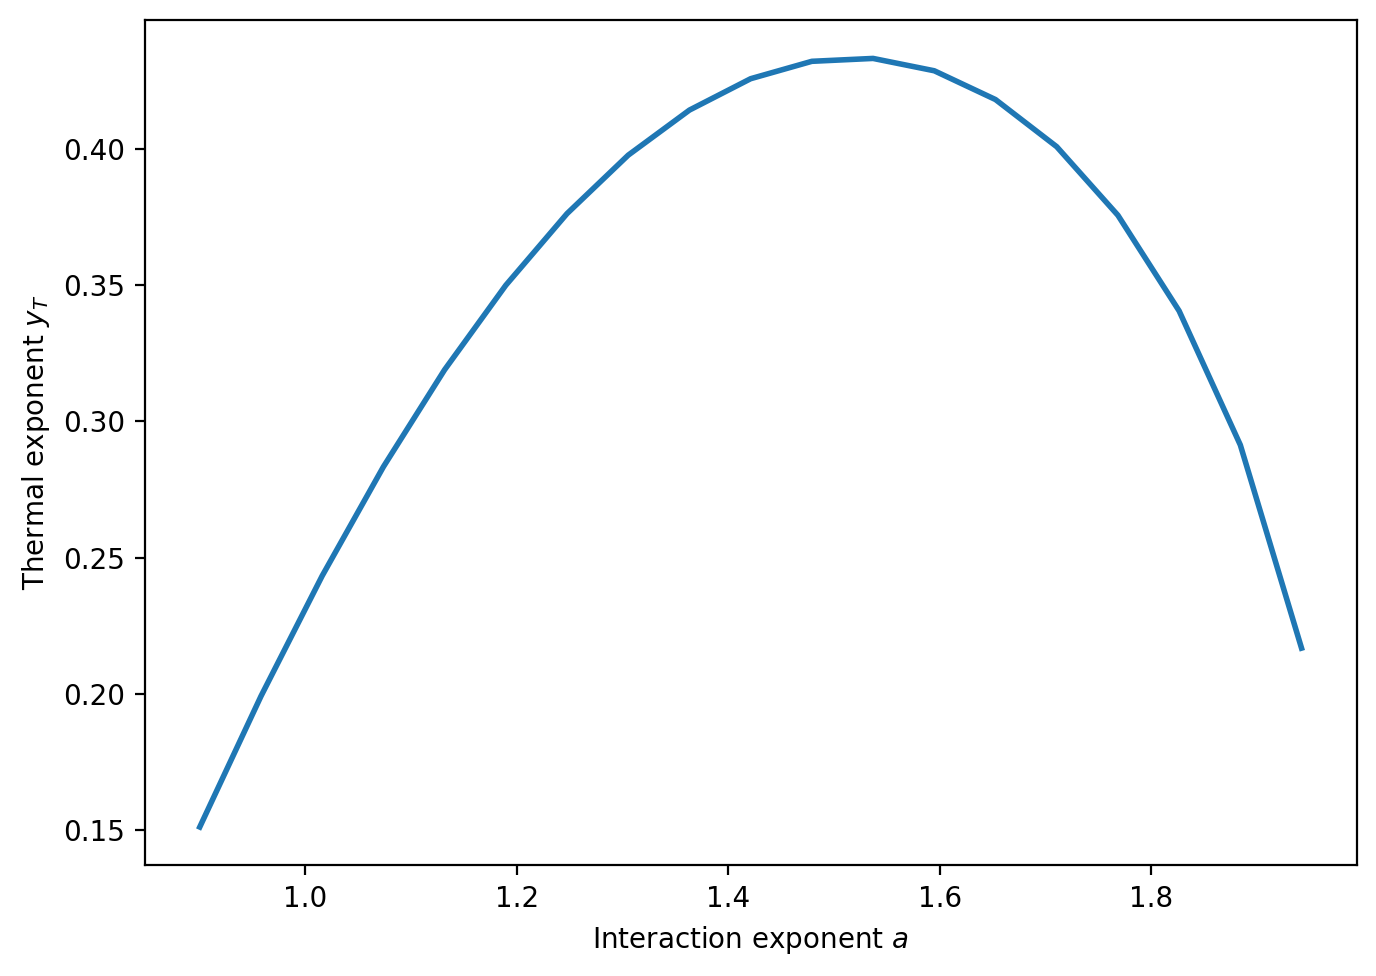

In [9]:
a_values = np.linspace(0.9, 2.0, 20)
D = 3500 # full cutoff
n = 1000 # number of head couplings
b = 3.0 # RG rescaling factor
eps0 = 1e-7 # finite-difference step
newton_tol = 1e-10

yT_values = []
Jc_values = []

# Consistency check
r_max = (D - 2) // 3
if n > r_max:
    raise ValueError(f"Choose n <= r_max = {r_max}")

# ---------------------------
# Main loop over a
# ---------------------------
for a in a_values:
    print(f"\n=== Processing a = {a:.3f} ===")

    # 1) Find critical coupling Jc(a)
    Jc = find_Jc(a)
    print(f"Jc(a={a:.3f}) = {Jc:.6g}")
    Jc_values.append(Jc)

    # 2) Initial guess for Newton (power-law head)
    x0 = np.zeros(n + 1)
    for r in range(1, n + 1):
        x0[r] = Jc / (r ** a)

    # 3) Newton–Raphson fixed point
    x_star, J_star_full, info = fixed_point_solver(
        a=a, D=D, n=n, x0_head=x0, tol_F=newton_tol, verbose=False)

    if not info["converged"]:
        print("⚠ Newton did not fully converge; skipping this a.")
        yT_values.append(np.nan)
        continue

    # 4–6) Compute thermal exponent yT
    yT, lambda_T, eigvals, Tmat = thermal_exponent_yT(
        x_head_star=x_star, a=a, D=D, n=n, b=b, eps0=eps0, verbose=False)

    print(f"yT(a={a:.3f}) = {yT:.6f}")
    yT_values.append(yT)

# Convert to arrays
a_values = np.array(a_values)
yT_values = np.array(yT_values)

# ---------------------------
# Plot yT vs a
# ---------------------------
plt.figure(figsize=(7, 5))
plt.plot(a_values, yT_values, "-", lw=2)
plt.xlabel("Interaction exponent $a$")
plt.ylabel("Thermal exponent $y_T$")
plt.tight_layout()
plt.show()

## Magnetic exponent yH

In [12]:
def magnetic_exponent_yH(J_star, eps=1e-8, b=3.0):
    alpha = dH_dH(J_star, eps=eps)

    if not np.isfinite(alpha) or alpha <= 0:
        raise RuntimeError(f"dH'/dH invalid or non-positive at fixed point: {alpha}")

    y_H = np.log(alpha) / np.log(b)
    return y_H, alpha


=== Processing a = 0.900 ===
Jc(a=0.900) = 0.0811161
alpha=dH'/dH=1.7003422,  yH=0.483182

=== Processing a = 0.911 ===
Jc(a=0.911) = 0.0871773
alpha=dH'/dH=1.7149873,  yH=0.490988

=== Processing a = 0.922 ===
Jc(a=0.922) = 0.0932206
alpha=dH'/dH=1.7297264,  yH=0.498778

=== Processing a = 0.933 ===
Jc(a=0.933) = 0.099246
alpha=dH'/dH=1.7445556,  yH=0.506548

=== Processing a = 0.944 ===
Jc(a=0.944) = 0.10526
alpha=dH'/dH=1.7594705,  yH=0.514297

=== Processing a = 0.956 ===
Jc(a=0.956) = 0.111261
alpha=dH'/dH=1.7744669,  yH=0.522022

=== Processing a = 0.967 ===
Jc(a=0.967) = 0.117251
alpha=dH'/dH=1.7895404,  yH=0.529722

=== Processing a = 0.978 ===
Jc(a=0.978) = 0.123229
alpha=dH'/dH=1.8046867,  yH=0.537393

=== Processing a = 0.989 ===
Jc(a=0.989) = 0.129206
alpha=dH'/dH=1.8199014,  yH=0.545035

=== Processing a = 1.000 ===
Jc(a=1.000) = 0.135172
alpha=dH'/dH=1.8351799,  yH=0.552645

=== Processing a = 1.011 ===
Jc(a=1.011) = 0.141138
alpha=dH'/dH=1.8505179,  yH=0.560221

=== Pro

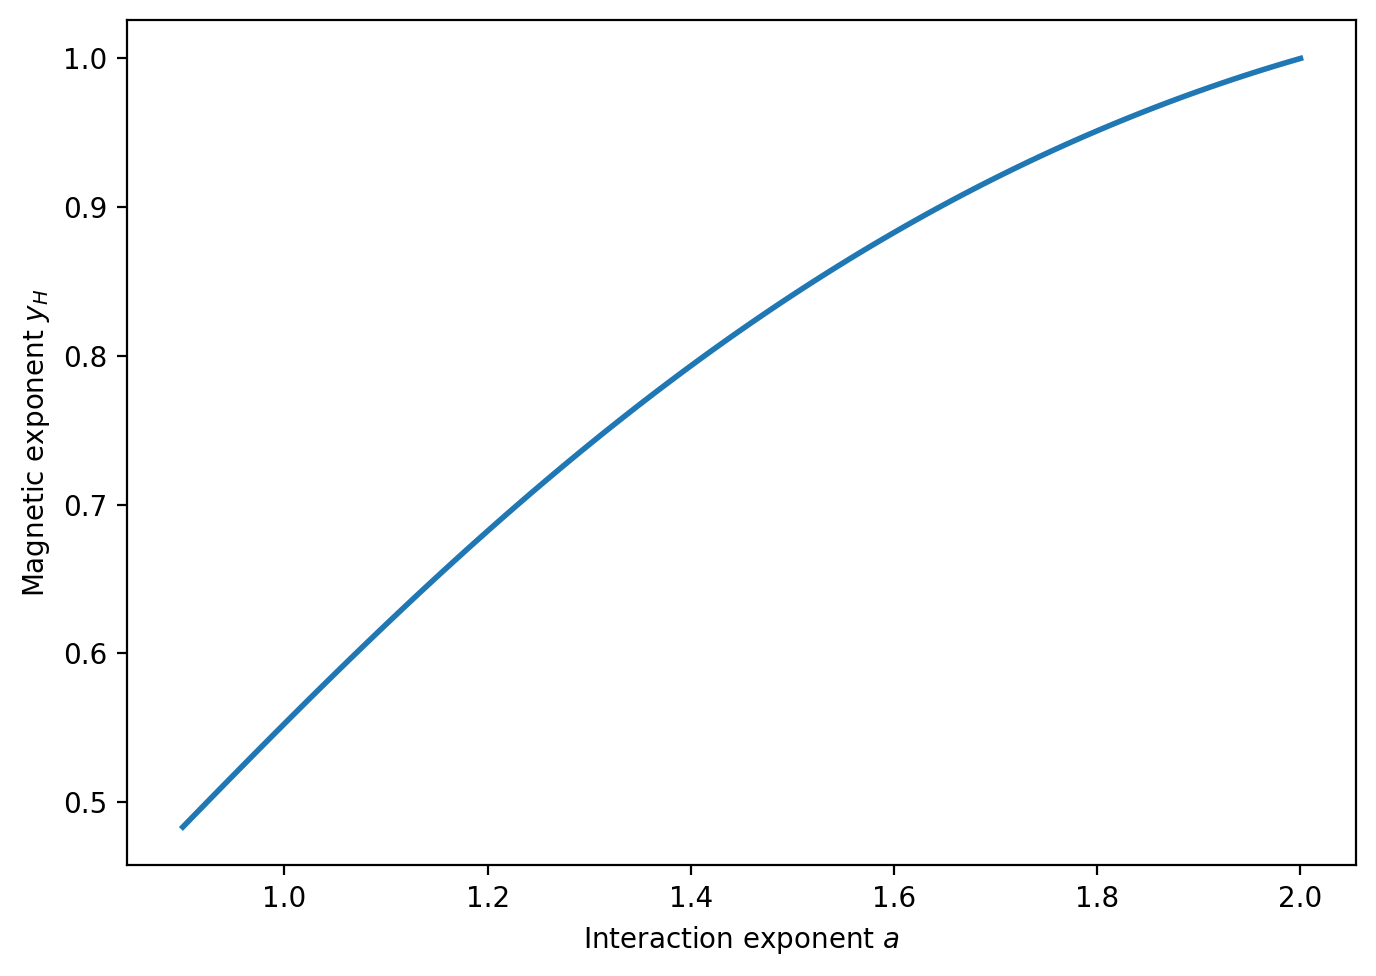

In [7]:
a_values = np.linspace(0.9, 2.0, 100)
D = 1000 # fixed cutoff for full J
n = 100 # head dimension (must satisfy n <= (D-2)//3)
b = 3.0 # RG scale factor
newton_tol = 1e-10

H_eps = 1e-8 # Finite-difference step for field derivative

yH_values = []
alpha_values = []   # alpha = dH'/dH
Jc_values = []

# Consistency check for exact-head region
r_max = (D - 2) // 3
if n > r_max:
    raise ValueError(f"Choose n <= r_max = {r_max}, but n={n}")

# ---------------------------
# Main loop over a
# ---------------------------
for a in a_values:
    print(f"\n=== Processing a = {a:.3f} ===")

    # 1) Find critical coupling Jc(a)
    Jc = find_Jc(a)
    print(f"Jc(a={a:.3f}) = {Jc:.6g}")
    Jc_values.append(Jc)

    # 2) Initial head guess from power law at Jc
    x0 = np.zeros(n + 1, dtype=np.float64)
    for r in range(1, n + 1):
        x0[r] = Jc / (r ** a)

    # 3) Newton fixed point for head, with fixed-size tail closure
    x_star_head, J_star_full, info = fixed_point_solver(
        a=a, D=D, n=n, x0_head=x0, tol_F=newton_tol, verbose=False)

    if not info.get("converged", False):
        print("⚠ Newton did not converge; skipping this a.")
        yH_values.append(np.nan)
        alpha_values.append(np.nan)
        continue

    # 4) Magnetic exponent yH at fixed point (use full J vector)
    try:
        yH, alpha = magnetic_exponent_yH(J_star_full, eps=H_eps, b=b)
    except RuntimeError as e:
        print(f"⚠ yH failed at a={a:.3f}: {e}")
        yH, alpha = np.nan, np.nan

    print(f"alpha=dH'/dH={alpha:.8g},  yH={yH:.6f}")
    yH_values.append(yH)
    alpha_values.append(alpha)

# Convert to arrays
a_values = np.array(a_values)
yH_values = np.array(yH_values)
alpha_values = np.array(alpha_values)

# ---------------------------
# Plot yH vs a
# ---------------------------
plt.figure(figsize=(7, 5))
plt.plot(a_values, yH_values, "-", lw=2)
plt.xlabel("Interaction exponent $a$")
plt.ylabel("Magnetic exponent $y_H$")
plt.tight_layout()
plt.show()

## All exponents

In [13]:
def compute_exponents_over_a_fixed_tail(
    a_min=1.0, a_max=2.0, num_points=20, D=200, n=50, d_dim=1.0, b=3.0,
    newton_tol=1e-10, eps_yT=1e-7, eps_yH=1e-8, verbose=True,):
    """
    Compute yT, yH via fixed-point Newton (fixed-size with tail), then derive
    standard critical exponents and return a dictionary of arrays.

    Constraints:
      - n must satisfy n <= (D-2)//3 so that all solved head couplings are in the exact-head
        region of rg_step (not overwritten by tail filling).
    """
    a_values = np.linspace(a_min, a_max, num_points)

    r_max = (D - 2) // 3
    if n > r_max:
        raise ValueError(f"Need n <= r_max=(D-2)//3 = {r_max}, but got n={n}.")

    # Storage arrays
    yT_arr = np.full(num_points, np.nan, dtype=np.float64)
    yH_arr = np.full(num_points, np.nan, dtype=np.float64)

    beta_arr  = np.full(num_points, np.nan, dtype=np.float64)
    delta_arr = np.full(num_points, np.nan, dtype=np.float64)
    eta_arr   = np.full(num_points, np.nan, dtype=np.float64)
    nu_arr    = np.full(num_points, np.nan, dtype=np.float64)
    alpha_arr = np.full(num_points, np.nan, dtype=np.float64)
    gamma_arr = np.full(num_points, np.nan, dtype=np.float64)

    Jc_arr    = np.full(num_points, np.nan, dtype=np.float64)
    lamT_arr  = np.full(num_points, np.nan, dtype=np.float64)  # optional diagnostics
    alphaH_arr = np.full(num_points, np.nan, dtype=np.float64) # optional diagnostics

    for i, a in enumerate(a_values):
        if verbose:
            print(f"\n=== Computing exponents at a = {a:.4f} ===")

        # 1) Find critical coupling Jc(a)
        Jc = find_Jc(a)
        Jc_arr[i] = Jc
        if verbose:
            print(f"  Jc = {Jc:.8g}")

        # 2) Initial guess for Newton: head couplings from power law at Jc
        x0 = np.zeros(n + 1, dtype=np.float64)
        for r in range(1, n + 1):
            x0[r] = Jc / (r ** a)

        # 3) Newton fixed point (head variables), fixed-size tail closure inside solver
        x_star_head, J_star_full, info = fixed_point_solver(
            a=a,
            D=D,
            n=n,
            x0_head=x0,
            tol_F=newton_tol,
            verbose=False
        )

        if not info.get("converged", False):
            if verbose:
                print(f"  ⚠ Newton failed (reason={info.get('reason','?')}, F_norm={info.get('F_norm',np.nan):.3e}); skipping.")
            continue

        # 4) yT from recursion matrix dR/dx at fixed point
        try:
            yT, lamT, eigvals, Tmat = thermal_exponent_yT(
                x_head_star=x_star_head,
                a=a, D=D, n=n,
                b=b, eps0=eps_yT,
                verbose=False
            )
        except Exception as e:
            if verbose:
                print(f"  ⚠ yT failed: {e}")
            continue

        yT_arr[i] = yT
        lamT_arr[i] = lamT
        if verbose:
            print(f"  yT = {yT:.8g}   (lambda_T={lamT:.8g})")

        # 5) yH from dH'/dH at fixed point (evaluate on full J*)
        try:
            yH, alphaH = magnetic_exponent_yH(J_star_full, eps=eps_yH, b=b)
        except Exception as e:
            if verbose:
                print(f"  ⚠ yH failed: {e}")
            continue

        yH_arr[i] = yH
        alphaH_arr[i] = alphaH
        if verbose:
            print(f"  yH = {yH:.8g}   (alpha=dH'/dH={alphaH:.8g})")

        # 6) Derived exponents (standard hyperscaling-style relations used in your snippet)
        #    Note: validity depends on regime; you are intentionally using these same formulas.
        nu = 1.0 / yT
        nu_arr[i] = nu

        beta = (d_dim - yH) / yT
        beta_arr[i] = beta

        # delta blows up if d_dim == yH; guard is implicit in np.nan if division errors occur
        delta = yH / (d_dim - yH)
        delta_arr[i] = delta

        eta = 2.0 + d_dim - 2.0 * yH
        eta_arr[i] = eta

        alpha = 2.0 - d_dim / yT
        alpha_arr[i] = alpha

        gamma = (2.0 * yH - d_dim) / yT
        gamma_arr[i] = gamma

        if verbose:
            print(f"  ν={nu:.6g}, β={beta:.6g}, δ={delta:.6g}, η={eta:.6g}, α={alpha:.6g}, γ={gamma:.6g}")

    return {
        "a": a_values,
        "Jc": Jc_arr,
        "yT": yT_arr,
        "yH": yH_arr,
        "beta": beta_arr,
        "delta": delta_arr,
        "eta": eta_arr,
        "nu": nu_arr,
        "alpha": alpha_arr,
        "gamma": gamma_arr,
        # optional diagnostics
        "lambda_T": lamT_arr,
        "alphaH": alphaH_arr,
        "D": D,
        "n": n,
        "b": b,
        "d": d_dim,
        "eps_yT": eps_yT,
        "eps_yH": eps_yH,
    }


=== Computing exponents at a = 0.8000 ===
  Jc = 0.025444999
  yT = 0.060438686   (lambda_T=1.0686527)
  yH = 0.41256487   (alpha=dH'/dH=1.5734157)
  ν=16.5457, β=9.71952, δ=0.702316, η=2.17487, α=-14.5457, γ=-2.89335

=== Computing exponents at a = 0.8081 ===
  Jc = 0.030022178
  yT = 0.068085984   (lambda_T=1.0776687)
  yH = 0.41825408   (alpha=dH'/dH=1.5832807)
  ν=14.6873, β=8.54428, δ=0.718963, η=2.16349, α=-12.6873, γ=-2.40126

=== Computing exponents at a = 0.8161 ===
  Jc = 0.034581477
  yT = 0.075678664   (lambda_T=1.0866956)
  yH = 0.42394628   (alpha=dH'/dH=1.5932128)
  ν=13.2138, β=7.61184, δ=0.735949, η=2.15211, α=-11.2138, γ=-2.00991

=== Computing exponents at a = 0.8242 ===
  Jc = 0.039116937
  yT = 0.083215352   (lambda_T=1.0957307)
  yH = 0.42964051   (alpha=dH'/dH=1.6032108)
  ν=12.017, β=6.85402, δ=0.75328, η=2.14072, α=-10.017, γ=-1.69102

=== Computing exponents at a = 0.8322 ===
  Jc = 0.043640477
  yT = 0.090695177   (lambda_T=1.1047718)
  yH = 0.43533587   (al

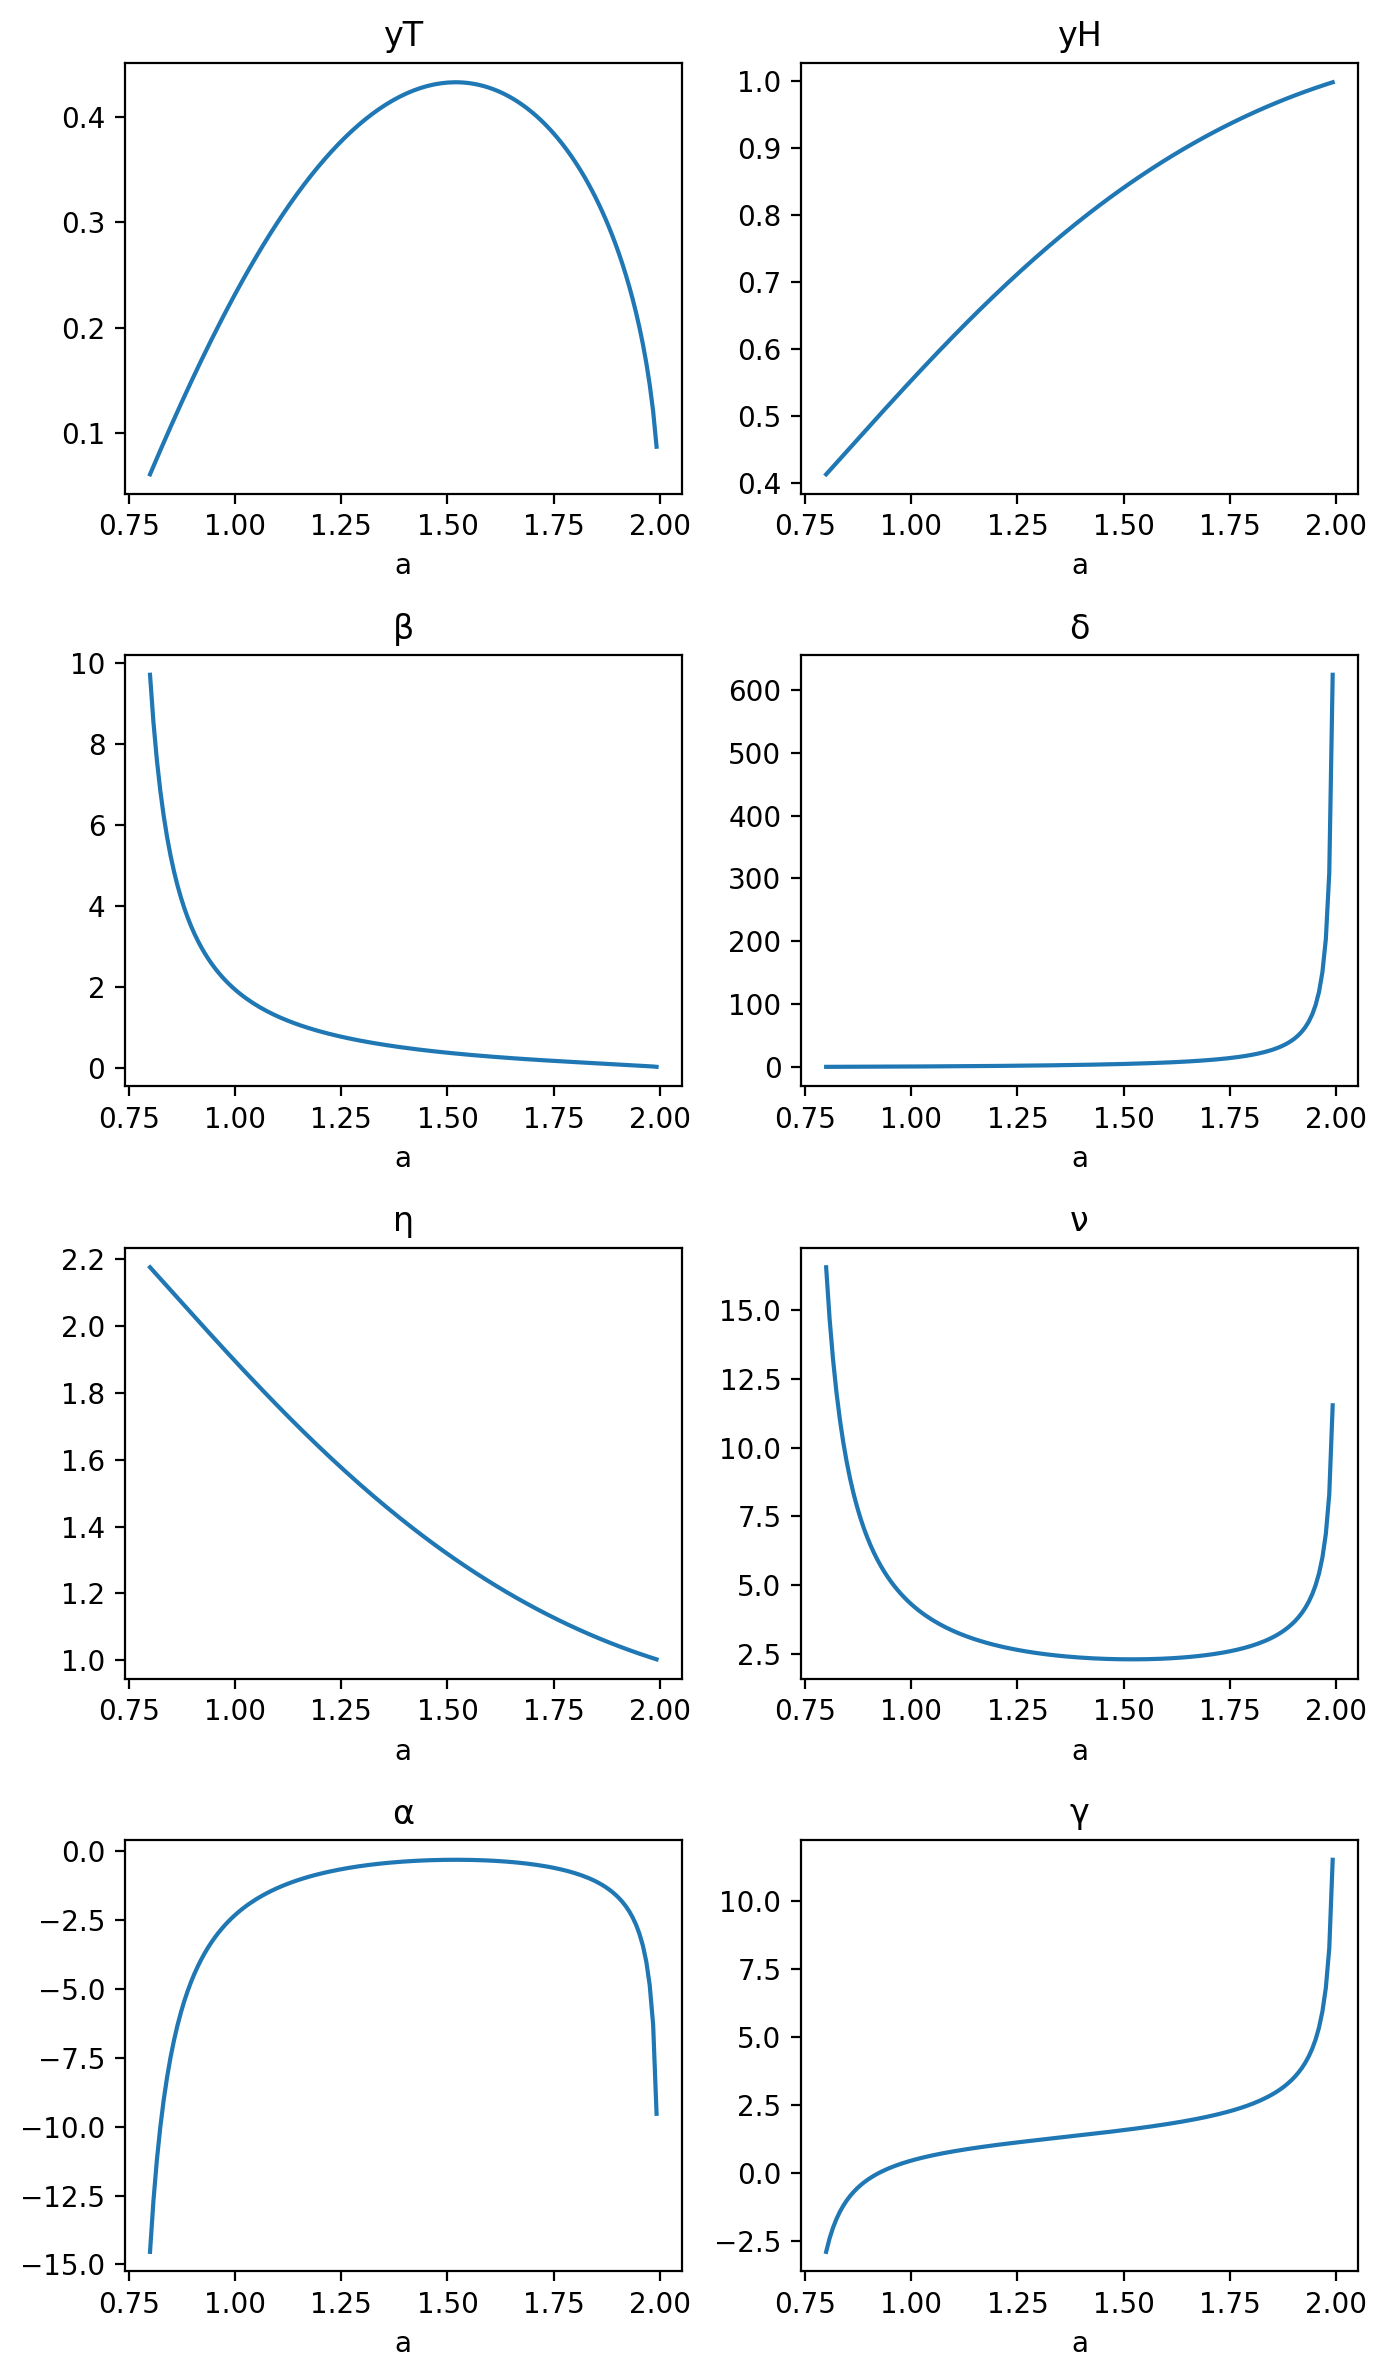

In [15]:
result = compute_exponents_over_a_fixed_tail(
    a_min=0.8, a_max=2.0,
    num_points=150,
    D=500,            # fixed-size cutoff
    n=150,             # head dimension (must satisfy n <= (D-2)//3)
    d_dim=1.0,
    b=3.0,
    newton_tol=1e-10,
    eps_yT=1e-7,
    eps_yH=1e-8,
    verbose=True
)

a = result["a"]
exps = [
    ("yT",     result["yT"]),
    ("yH",     result["yH"]),
    ("β",      result["beta"]),
    ("δ",      result["delta"]),
    ("η",      result["eta"]),
    ("ν",      result["nu"]),
    ("α",      result["alpha"]),
    ("γ",      result["gamma"]),
]

fig, axes = plt.subplots(4, 2, figsize=(7, 12))
axes = axes.flatten()

for i, (name, vals) in enumerate(exps):
    ax = axes[i]
    ax.plot(a, vals)
    ax.set_title(name)
    ax.set_xlabel("a")

plt.tight_layout()
plt.show()

In [16]:
# Save data
import os, json
import numpy as np

outdir = "../data/exponents/rg_exponents"
os.makedirs(outdir, exist_ok=True)

stem = f"exponents_a{result['a'][0]:.3f}-{result['a'][-1]:.3f}_N{len(result['a'])}_D{result['D']}_n{result['n']}_b{result['b']}_d{result['d']}"
npz_path = os.path.join(outdir, f"{stem}.npz")
meta_path = os.path.join(outdir, f"{stem}.meta.json")

# Save arrays into a compressed NPZ
np.savez_compressed(
    npz_path,
    a=result["a"],
    Jc=result["Jc"],
    yT=result["yT"],
    yH=result["yH"],
    beta=result["beta"],
    delta=result["delta"],
    eta=result["eta"],
    nu=result["nu"],
    alpha=result["alpha"],
    gamma=result["gamma"],
    lambda_T=result["lambda_T"],
    alphaH=result["alphaH"],
)

# Save run metadata (pure python scalars) into JSON
meta = {
    "D": int(result["D"]),
    "n": int(result["n"]),
    "b": float(result["b"]),
    "d": float(result["d"]),
    "eps_yT": float(result["eps_yT"]),
    "eps_yH": float(result["eps_yH"]),
    "a_min": float(result["a"][0]),
    "a_max": float(result["a"][-1]),
    "num_points": int(len(result["a"])),
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("Saved:", npz_path)
print("Saved:", meta_path)


Saved: ../data/exponents/rg_exponents/exponents_a0.800-2.000_N150_D500_n150_b3.0_d1.0.npz
Saved: ../data/exponents/rg_exponents/exponents_a0.800-2.000_N150_D500_n150_b3.0_d1.0.meta.json


In [11]:
# Load data
import json
import numpy as np

# Option 1: hardcode the paths you printed previously
# npz_path = "rg_exponents_results/<your-file>.npz"
# meta_path = "rg_exponents_results/<your-file>.meta.json"

loaded = np.load(npz_path)  # dict-like
loaded_result = {k: loaded[k] for k in loaded.files}  # arrays only

with open(meta_path, "r", encoding="utf-8") as f:
    loaded_meta = json.load(f)

# If you want the same structure as your `result` dict:
loaded_result.update(loaded_meta)

print("Loaded keys:", sorted(loaded_result.keys()))
print("a-range:", loaded_result["a"][0], "→", loaded_result["a"][-1], "N=", len(loaded_result["a"]))


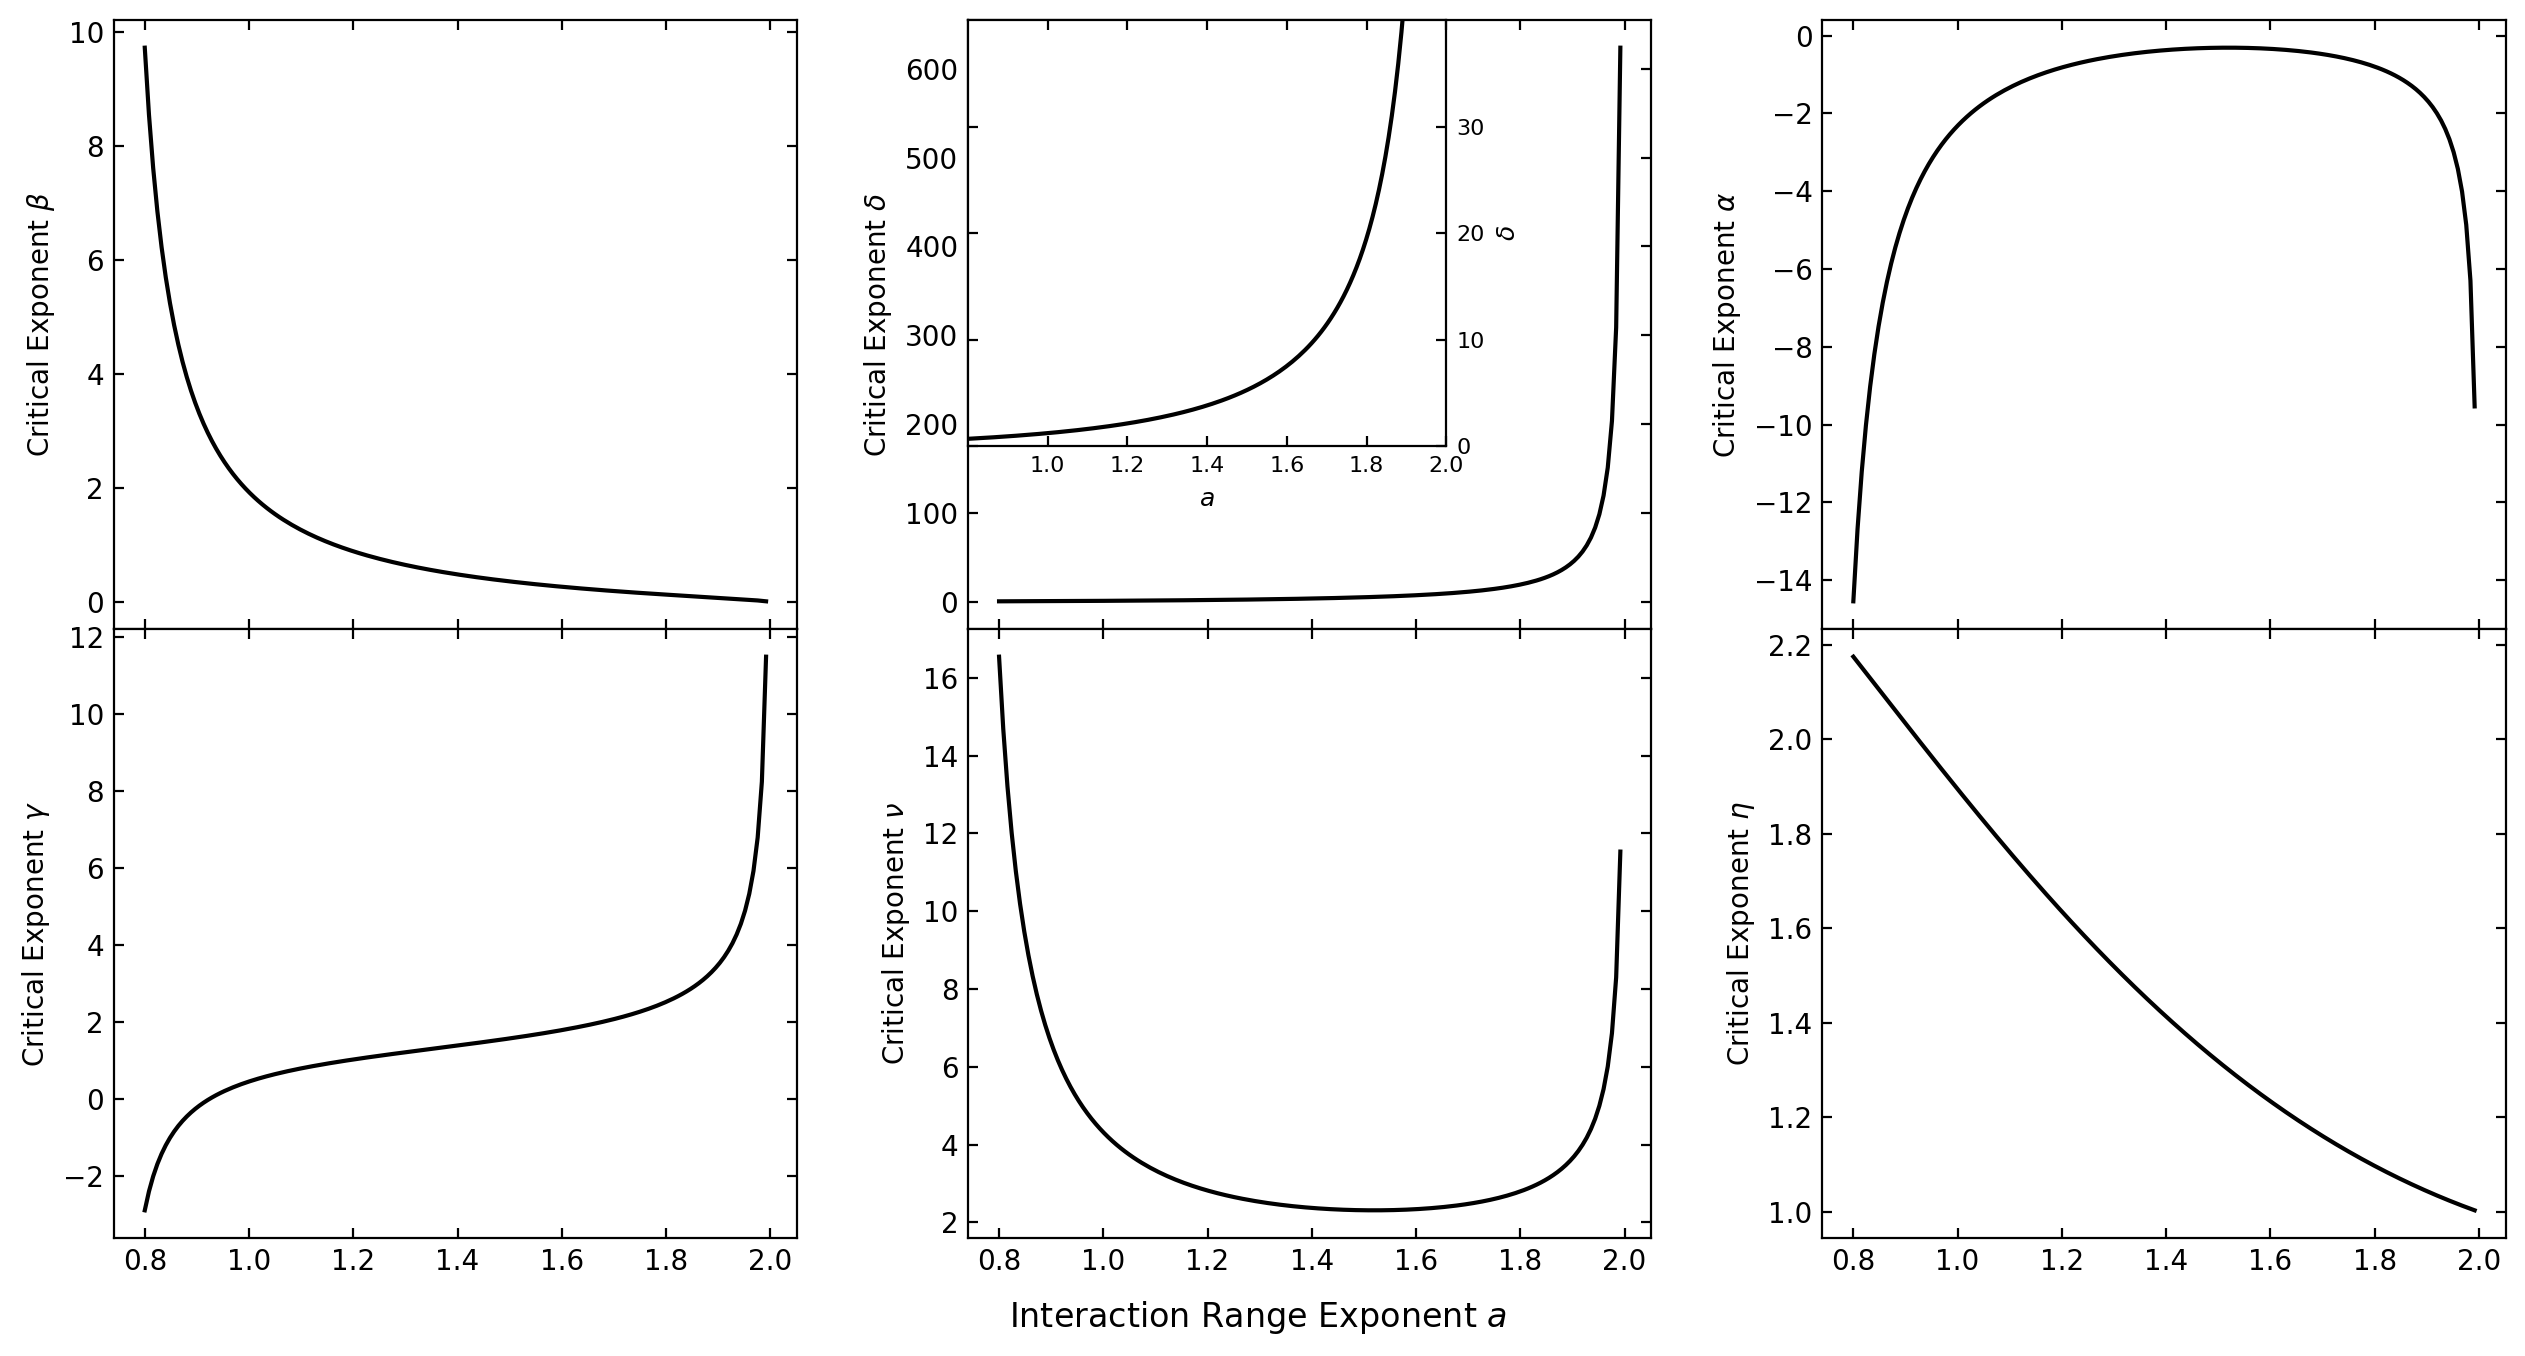

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

a = result["a"]

fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharex=True)
fig.subplots_adjust(left=0.06, right=0.98, bottom=0.08, top=0.95, wspace=0.25, hspace=0)

# Helper: ticks inside for any axis
def ticks_inside(ax):
    ax.tick_params(direction="in", which="both", top=True, right=True)

# ---------- First row ----------
axes[0, 0].plot(a, result["beta"], c='k')
axes[0, 0].set_ylabel(r"Critical Exponent $\beta$")
ticks_inside(axes[0, 0])

axes[0, 1].plot(a, result["delta"], c='k')
axes[0, 1].set_ylabel(r"Critical Exponent $\delta$")
ticks_inside(axes[0, 1])

# Inset for delta
axins = inset_axes(axes[0, 1], width="70%", height="70%", loc="upper left", borderpad=0)
axins.plot(a, result["delta"], c='k')
axins.set_xlim(a.min(), a.max())
axins.set_ylim(0, 40)
axins.set_xlabel(r"$a$", fontsize=9)
axins.set_ylabel(r"$\delta$", fontsize=9)
axins.set_xticks([1, 1.2, 1.4, 1.6, 1.8, 2])
axins.yaxis.set_label_position("right")
axins.yaxis.tick_right()
axins.set_yticks([0, 10, 20, 30,])
#axins.set_yticklabels([r"$\delta_1$", r"$\delta_2$", r"$\delta_3$"])
axins.tick_params(direction="in", which="both", right=True, left=True, labelright=True, labelleft=False, top=True, labelsize=8)

axes[0, 2].plot(a, result["alpha"], c='k')
axes[0, 2].set_ylabel(r"Critical Exponent $\alpha$")
ticks_inside(axes[0, 2])

# ---------- Second row ----------
axes[1, 0].plot(a, result["gamma"], c='k')
axes[1, 0].set_ylabel(r"Critical Exponent $\gamma$")
ticks_inside(axes[1, 0])

axes[1, 1].plot(a, result["nu"], c='k')
axes[1, 1].set_ylabel(r"Critical Exponent $\nu$")
ticks_inside(axes[1, 1])

axes[1, 2].plot(a, result["eta"], c='k')
axes[1, 2].set_ylabel(r"Critical Exponent $\eta$")
ticks_inside(axes[1, 2])

fig.supxlabel(r"Interaction Range Exponent $a$", fontsize=12)

plt.savefig("exponents.png")
plt.show()